In [77]:
import matplotlib.pyplot as plt
from DataLoader import DataLoader

class_names = [
    {"name": "Wall", "classIndex": 0, "ADE20K_classIndex": 0},
    {"name": "Sky", "classIndex": 1, "ADE20K_classIndex": 2},
    {"name": "Tree", "classIndex": 2, "ADE20K_classIndex": 4},
    {"name": "Route", "classIndex": 3, "ADE20K_classIndex": 6},
    {"name": "Grass", "classIndex": 4, "ADE20K_classIndex": 9},
    {"name": "Earth", "classIndex": 5, "ADE20K_classIndex": 13},
    {"name": "Mountain", "classIndex": 6, "ADE20K_classIndex": 16},
    {"name": "Plant", "classIndex": 7, "ADE20K_classIndex": 17},
    {"name": "Water", "classIndex": 8, "ADE20K_classIndex": 21},
    {"name": "Sea", "classIndex": 9, "ADE20K_classIndex": 26},
    {"name": "Field", "classIndex": 10, "ADE20K_classIndex": 29},
    {"name": "Rock", "classIndex": 11, "ADE20K_classIndex": 34},
    {"name": "Sand", "classIndex": 12, "ADE20K_classIndex": 46},
    {"name": "River", "classIndex": 13, "ADE20K_classIndex": 60},
    {"name": "Hill", "classIndex": 14, "ADE20K_classIndex": 68},
    {"name": "Land", "classIndex": 15, "ADE20K_classIndex": 94},
    {"name": "Waterfall", "classIndex": 16, "ADE20K_classIndex": 113},
]

class_merge_map = {
    3:0, 4:2, 7:2, 9: 8, 13: 8, 16:8, 10:5, 12:5, 15:5, 11:6, 14:6 
}


class_names = [
    "Wall",
    "Sky",
    "Tree",
    "Route",
    "Grass",
    "Earth",
    "Mountain",
    "Plant",
    "Water",
    "Sea",
    "Field",
    "Rock",
    "Sand",
    "River",
    "Hill",
    "Land",
    "Waterfall",
]


dataloader = DataLoader(class_merge_map=class_merge_map)
dataloader.load_data(1000)

image, mask = dataloader.get_image(1)

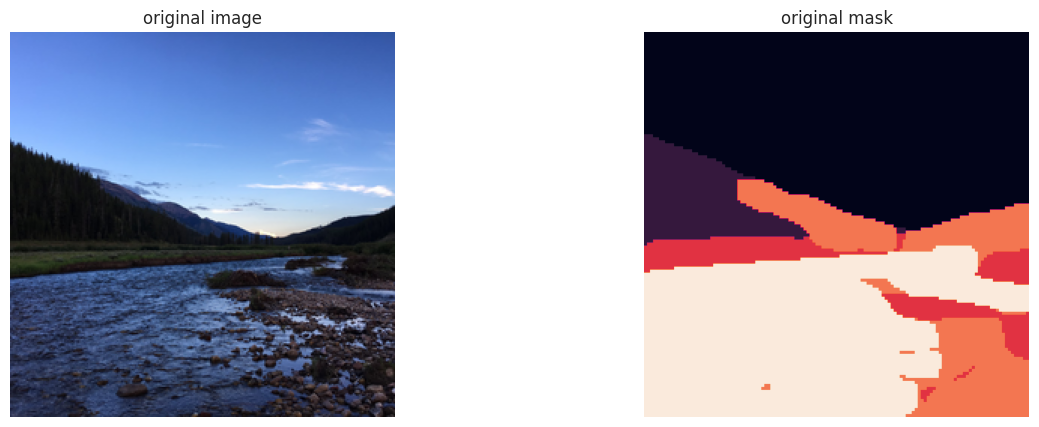

In [78]:
def visualize_process(images, titles):
    n = len(images)
    fig, ax = plt.subplots(1, n, figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax[i].imshow(image)
        ax[i].set_title(title)
        ax[i].axis("off")
    plt.show()

visualize_process([image, mask], ['original image', 'original mask'])

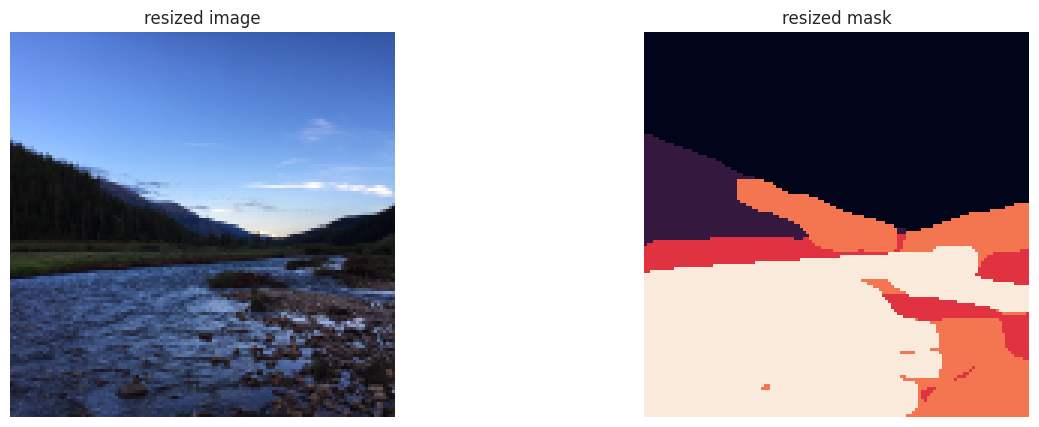

In [75]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.filters import gabor_kernel
from scipy.ndimage import convolve
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from typing import Tuple, List


def resize(image: np.ndarray, mask: np.ndarray, scale: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    """Resize image and mask by a scaling factor."""
    img_resized = cv2.resize(image, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    return img_resized, mask_resized

resized_image, resized_mask = resize(image, mask)
visualize_process([resized_image, resized_mask], ['resized image', 'resized mask'])

TypeError: 'Axes' object is not subscriptable

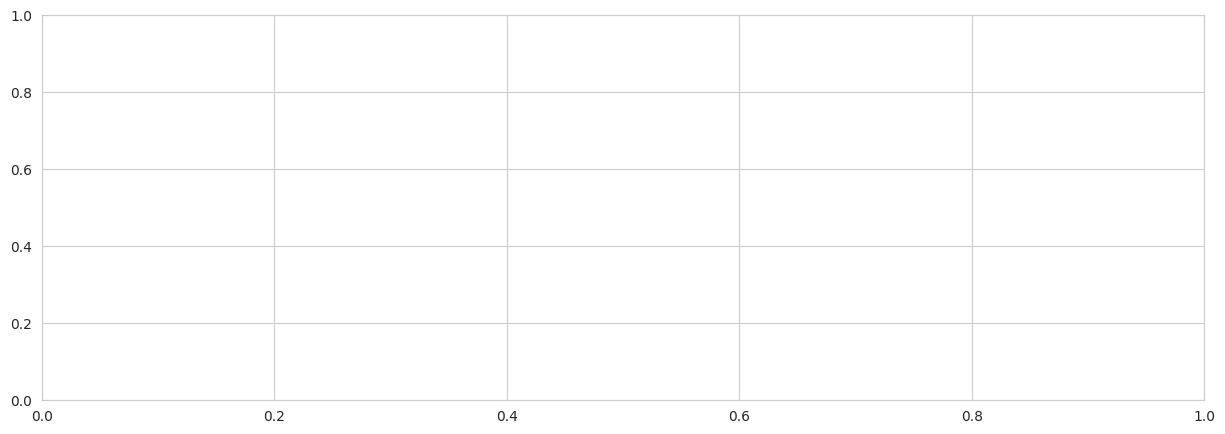

In [76]:
def equalize_hist(image: np.ndarray) -> np.ndarray:
    """Perform histogram equalization on a grayscale or RGB image."""
    if image.ndim == 2:
        return cv2.equalizeHist(image)
    channels = cv2.split(image)
    equalized_channels = [cv2.equalizeHist(chan) for chan in channels]
    return cv2.merge(equalized_channels)

def superpixel_segmentation(image: np.ndarray, n_segments: int = 100) -> np.ndarray:
    """Segment an image into superpixels."""
    return slic(image, n_segments=n_segments, compactness=10, start_label=1)

preprocessed = equalize_hist(resized_image)
segments = superpixel_segmentation(preprocessed)
visualize_process([preprocessed], ['equalized histogram image'])

In [56]:

def extract_hist(image: np.ndarray, segments: np.ndarray, superpixel_id: int) -> np.ndarray:
    """Extract a histogram for a specific superpixel."""
    mask_segment = (segments == superpixel_id).astype(np.uint8)
    hist = cv2.calcHist([image], [0, 1, 2], mask_segment, [3, 3, 3], [0, 256, 0, 256, 0, 256])
    return hist.flatten()


def generate_gabor_filter_bank(frequency: float = 0.1, n_orientations: int = 6) -> List[np.ndarray]:
    """Generate a Gabor filter bank with specified frequency and orientations."""
    return [
        gabor_kernel(frequency, theta=theta)
        for theta in np.linspace(0, np.pi, n_orientations, endpoint=False)
    ]


def extract_gabor_features(image: np.ndarray, filter_bank: List[np.ndarray]) -> np.ndarray:
    """Apply Gabor filters to an image and collect the responses."""
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    responses = [convolve(image, np.real(kernel), mode='reflect') for kernel in filter_bank]
    return np.stack(responses, axis=-1)


def compute_superpixel_features(
        segments: np.ndarray, gabor_responses: np.ndarray
) -> np.ndarray:
    """Compute features for each superpixel using Gabor filter responses."""
    num_superpixels = segments.max()
    num_filters = gabor_responses.shape[-1]
    features = np.zeros((num_superpixels, num_filters))

    for sp_label in range(1, num_superpixels + 1):
        mask = segments == sp_label
        for f in range(num_filters):
            response = gabor_responses[..., f]
            features[sp_label - 1, f] = response[mask].mean()
    return features


def extract_features(
        images: List[np.ndarray], masks: List[np.ndarray], gabor_filter_bank: List[np.ndarray]
) -> Tuple[np.ndarray, np.ndarray]:
    """Extract features and labels from a list of images and masks."""
    all_features, all_labels = [], []

    for image, mask in zip(images, masks):
        processed_image = equalize_hist(image)
        segments = superpixel_segmentation(processed_image)
        gabor_responses = extract_gabor_features(processed_image, gabor_filter_bank)

        num_superpixels = segments.max()
        image_features = []
        superpixel_labels = []

        for sp_label in range(1, num_superpixels + 1):
            sp_mask = segments == sp_label

            # Gabor features
            gabor_features = [
                gabor_responses[..., f][sp_mask].mean()
                for f in range(gabor_responses.shape[-1])
            ]

            # Histogram features
            hist = extract_hist(processed_image, segments, sp_label)
            hist_features = [
                hist.mean(), hist.var(), skew(hist), kurtosis(hist), np.sum(hist ** 2)
            ]

            # Combine features
            image_features.append(gabor_features + hist_features)

            # Determine superpixel label
            pixel_labels = mask[sp_mask].flatten()
            if pixel_labels.size > 0:
                superpixel_labels.append(np.bincount(pixel_labels).argmax())
            else:
                superpixel_labels.append(-1)

        all_features.append(np.array(image_features))
        all_labels.append(np.array(superpixel_labels))

    return np.vstack(all_features), np.hstack(all_labels)


# for (chan, color) in zip(chans, colors):
#     # Create a histogram for the current channel and plot it
#     hist = cv2.calcHist([chan], [0], mask_segment, [256], [0, 256])
#     plt.plot(hist, color=color)
#     plt.xlim([0, 256])
# 

gabor_filter_bank = generate_gabor_filter_bank()
# features, labels = extract_features(images, masks, gabor_filter_bank)

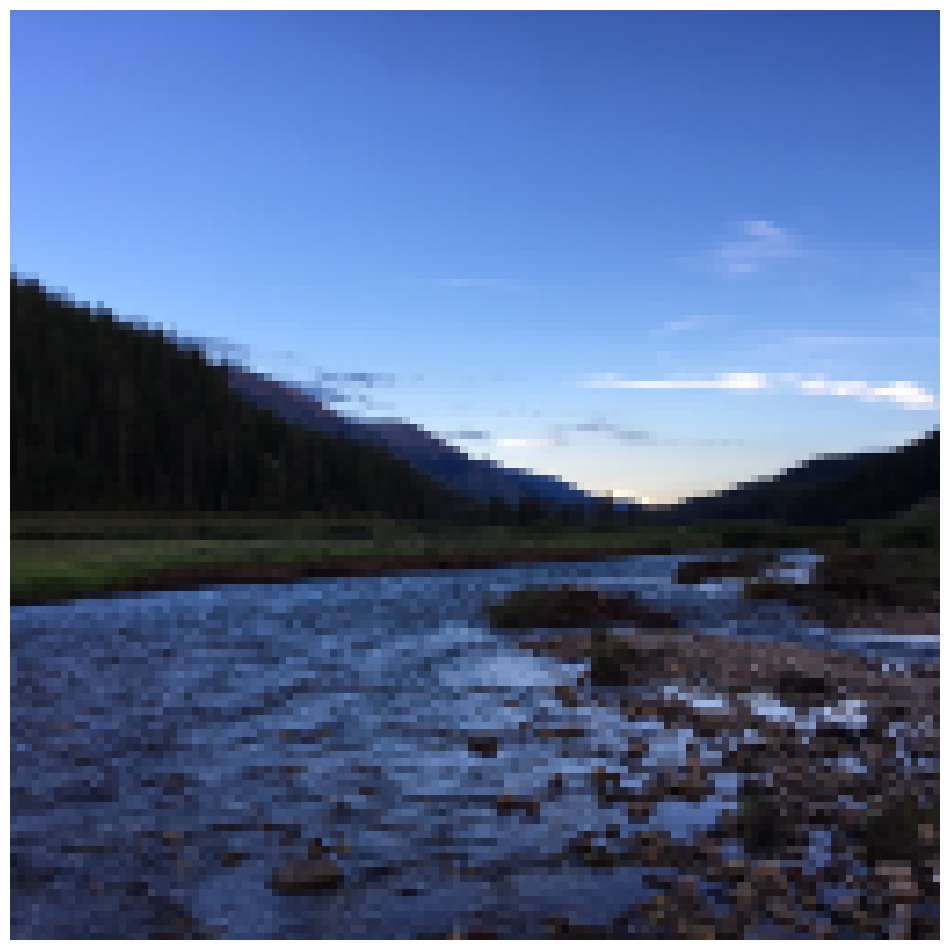

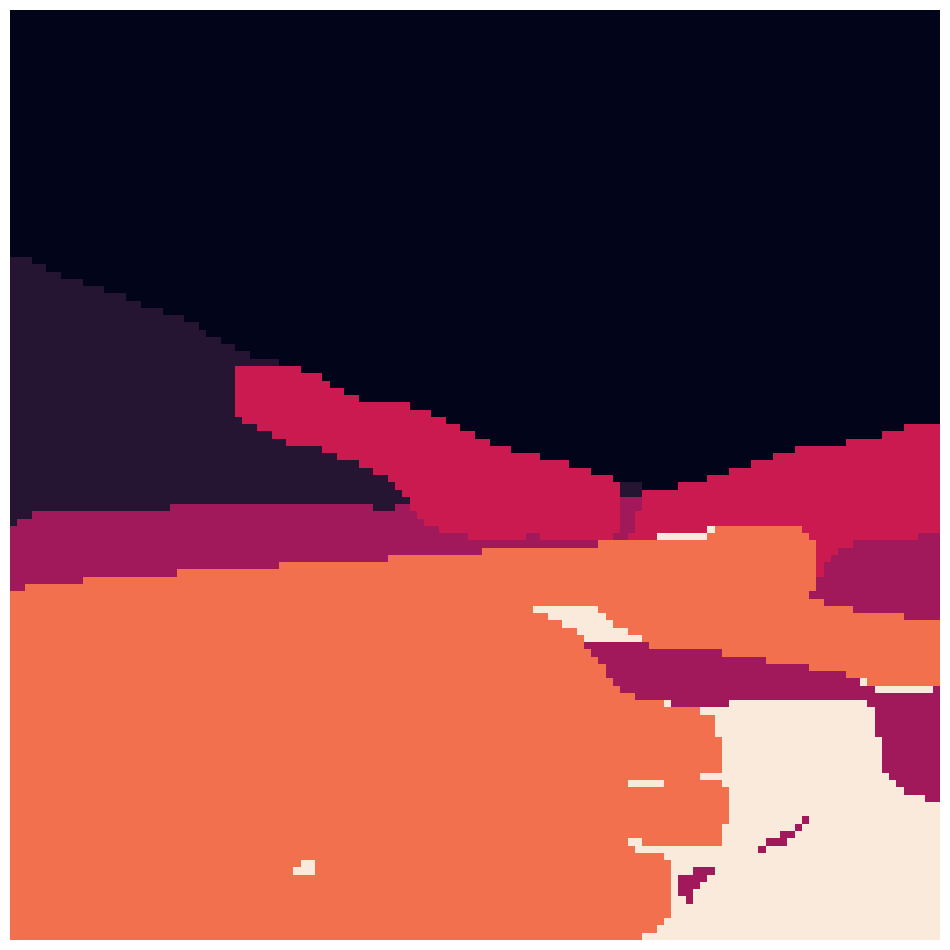

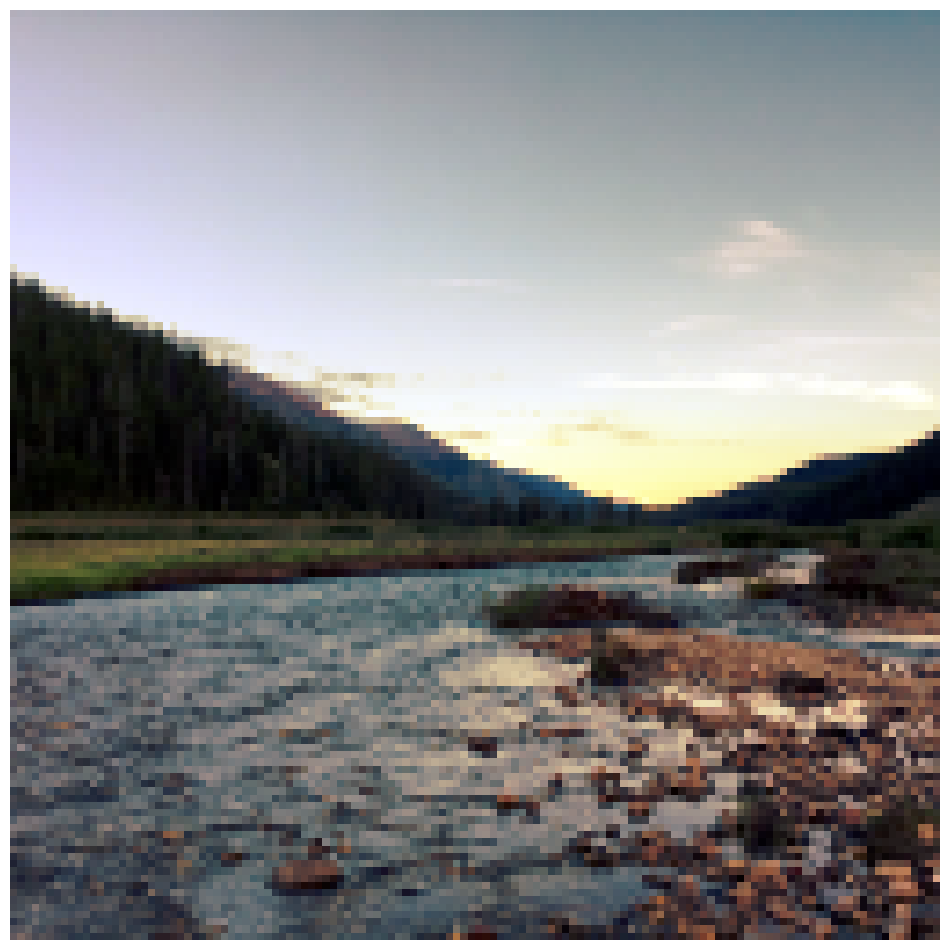

In [57]:
import cv
from skimage.color import label2rgb
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def show_image(image, title=''):
    fig, ax = plt.subplots(figsize=(12, 20))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

"""Visualize processing steps for a single image and mask."""
    # Step 1: Resize
resized_image, resized_mask = resize(image, mask)
    # Step 2: Equalize histogram
eq_image = equalize_hist(resized_image)
    # Step 3: Segment into superpixels
segments = superpixel_segmentation(eq_image)

    # Visualize resized image
show_image(resized_image, 'resized')
show_image(resized_mask, 'resized')
    # Visualize histogram equalized image
show_image(eq_image, 'equalized')

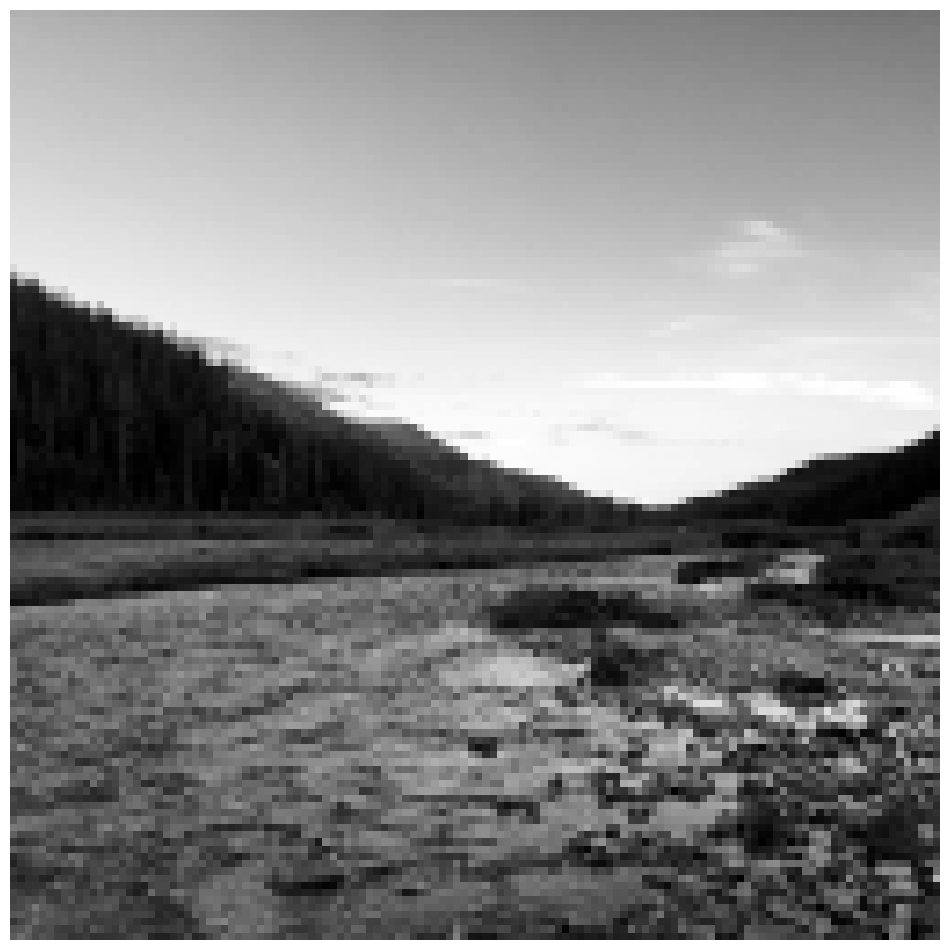

In [58]:
fig, ax = plt.subplots(figsize=(12, 20))
plt.imshow(cv2.cvtColor(eq_image, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.axis("off")
plt.show()

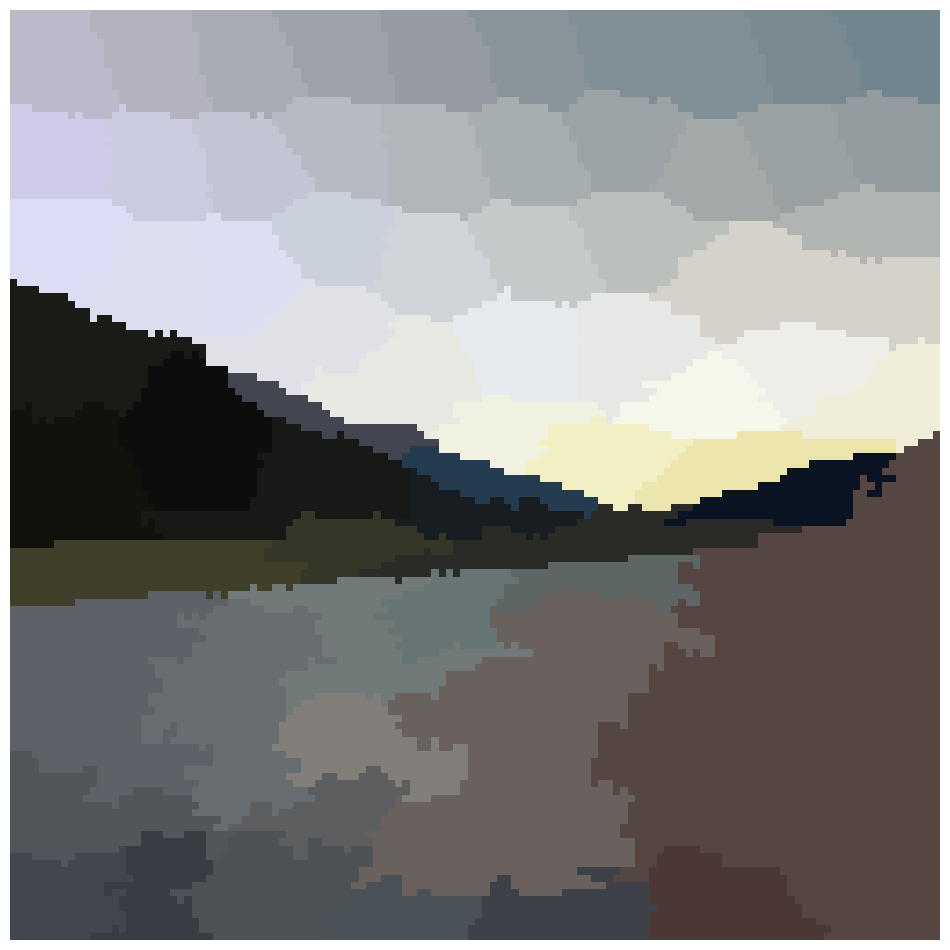

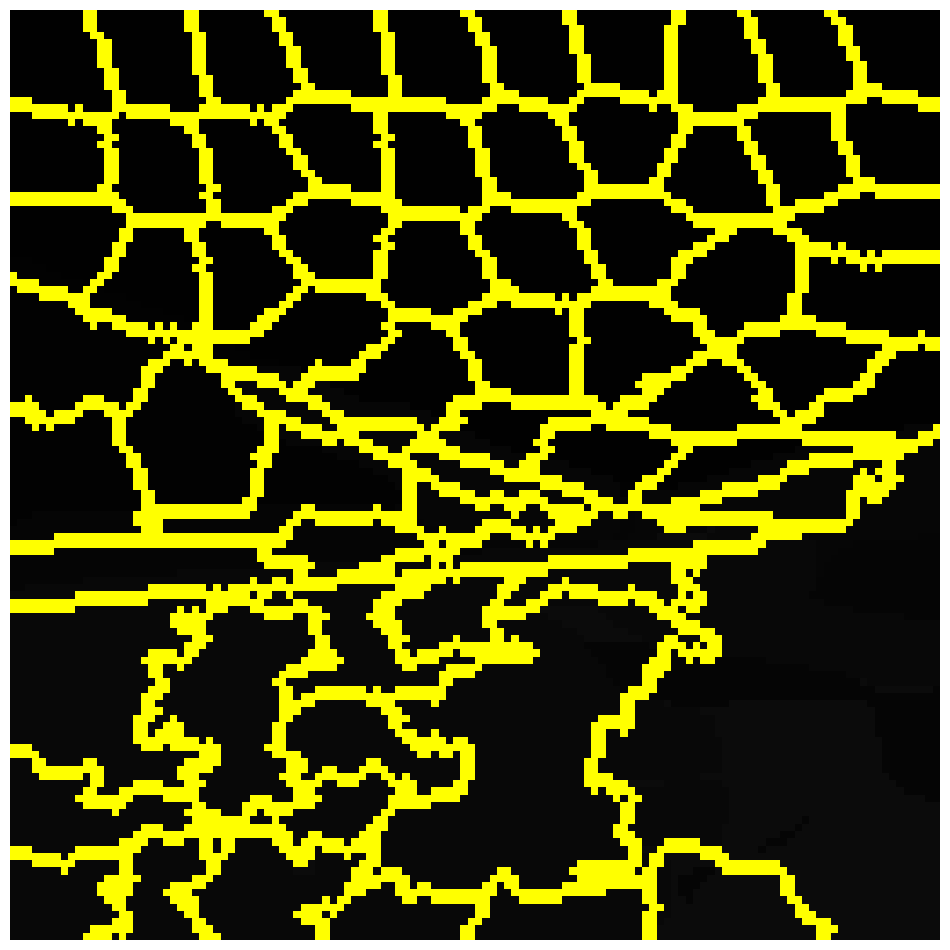

In [59]:
# Visualize superpixel segmentation
mean_segments = label2rgb(segments, image=eq_image, kind='avg')
show_image(mean_segments, "Superpixels")
show_image(mark_boundaries(resized_mask, segments), "Superpixels")

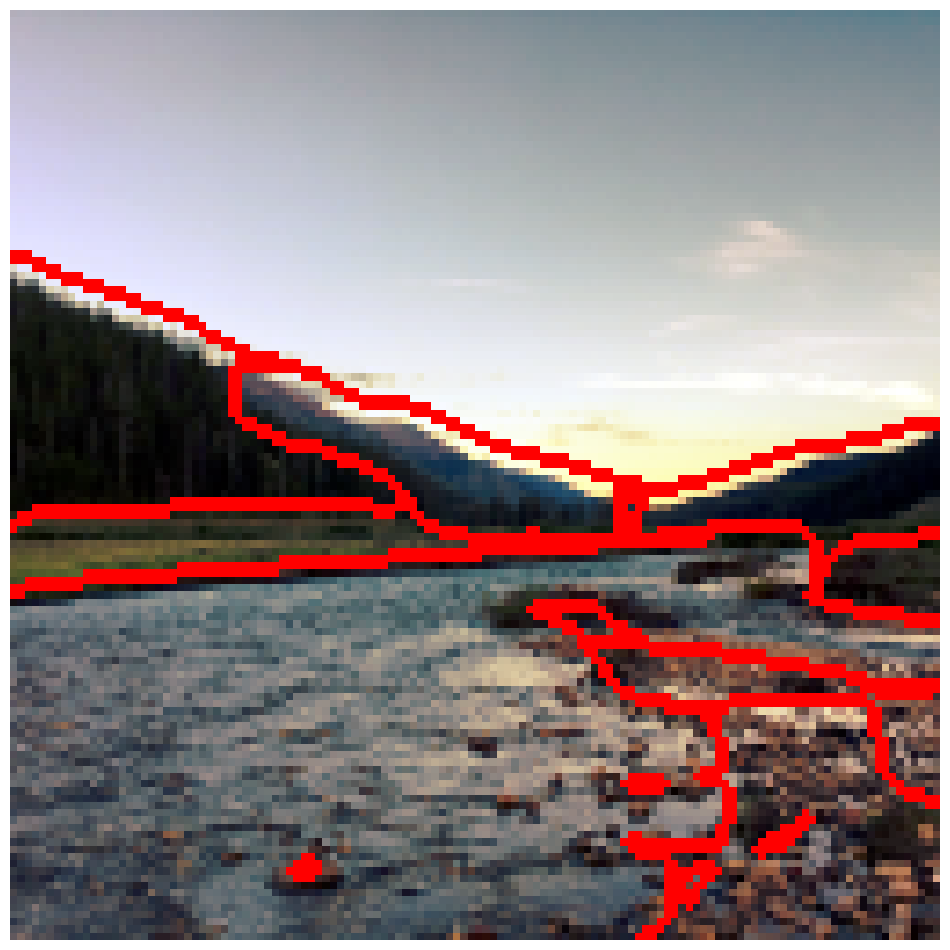

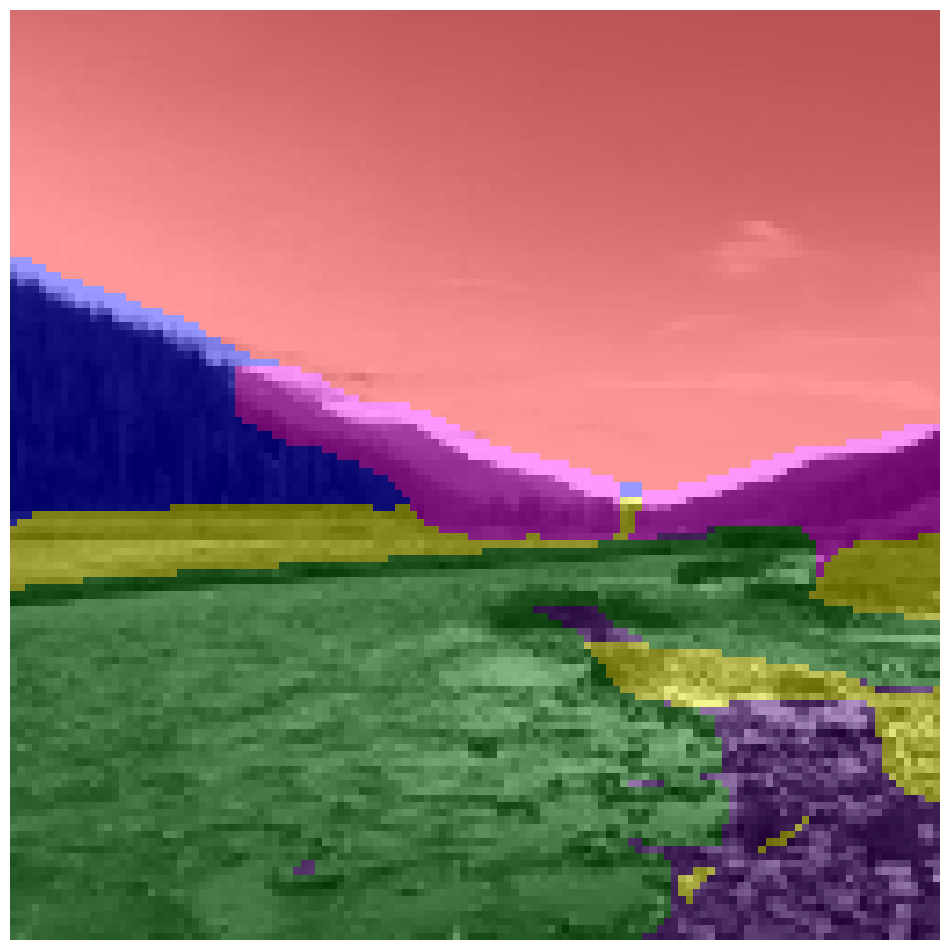

In [60]:
boundaries_image = mark_boundaries(eq_image, resized_mask, color=(1, 0, 0), mode='thick')
    
    # Optionally overlay mask regions with transparency
overlayed_image = label2rgb(resized_mask, image=eq_image, alpha=0.4)
    
    # Show superpixel boundaries
show_image(boundaries_image, "Superpixels with Boundaries")    
    # Show mask overlay
show_image(overlayed_image, "Superpixel Mask Overlay")

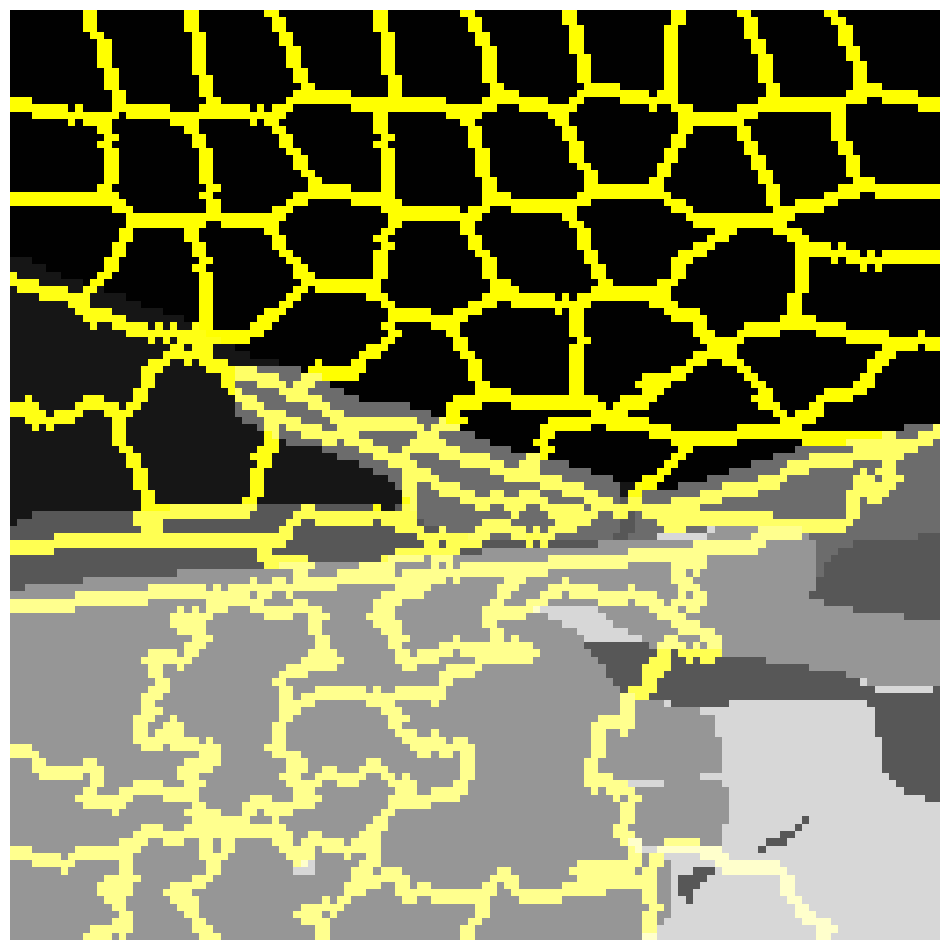

In [61]:

processed_mask = resized_mask - resized_mask.min()  # Shift classes to start from 0
    
    # Generate superpixel boundaries over the resized image
boundary_overlay = (mark_boundaries(resized_mask, segments, color=(1, 1, 0), mode='outer')*255).astype(np.uint8)
    
    # Convert the mask to a grayscale image with values normalized to [0, 255] for blending
mask_grayscale = ((processed_mask.astype(float) / processed_mask.max()) * 255).astype(np.uint8)
    
    # Blend the boundary overlay and mask
    # Mask in grayscale as background, boundaries highlighted
blended_image = cv2.addWeighted(
        boundary_overlay,
        1,  # Mask transparency
        cv2.cvtColor(mask_grayscale, cv2.COLOR_GRAY2RGB),
        0.8,  # Boundary overlay transparency
        0     # No bias added
    )
    
    # Show the combined visualization
show_image(blended_image, "Superpixels and Mask Combined")

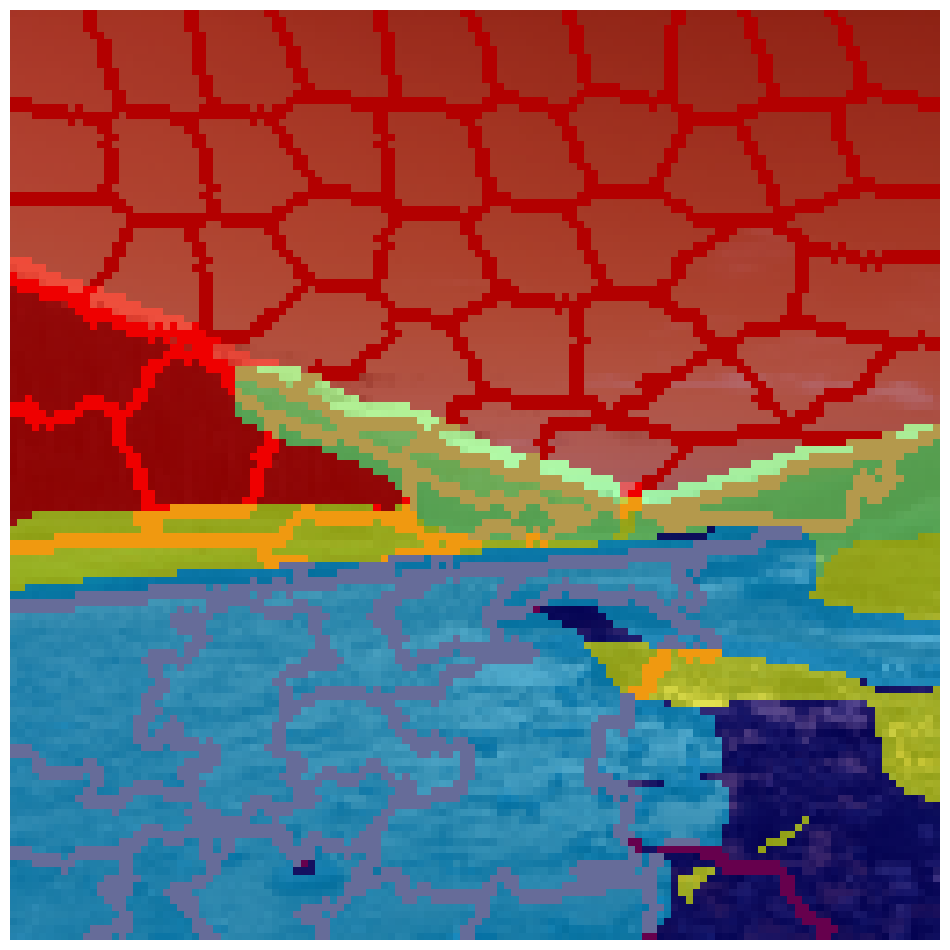

In [62]:
processed_mask = resized_mask - resized_mask.min()  # Shift classes to start from 0

# Generate superpixel boundaries over the resized image
boundary_overlay = (mark_boundaries(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB), segments, color=(1, 0, 0), mode='thick') * 255).astype(np.uint8)

# Normalize mask to enhance visibility (stretch to full intensity range)
mask_grayscale = ((processed_mask.astype(float) / processed_mask.max()) * 255).astype(np.uint8)

# Apply a colormap to the mask for better visibility (e.g., JET colormap)
mask_colored = cv2.applyColorMap(mask_grayscale, cv2.COLORMAP_JET)

# Combine the colored mask with the boundary overlay
blended_image = cv2.addWeighted(
    mask_colored,          # Colored mask for better visibility
    0.6,                   # Mask transparency
    boundary_overlay,      # Red boundary overlay
    0.4,                   # Boundary transparency
    0                      # No bias added
)

# Show the combined visualization
show_image(blended_image, "Enhanced Superpixels and Mask")

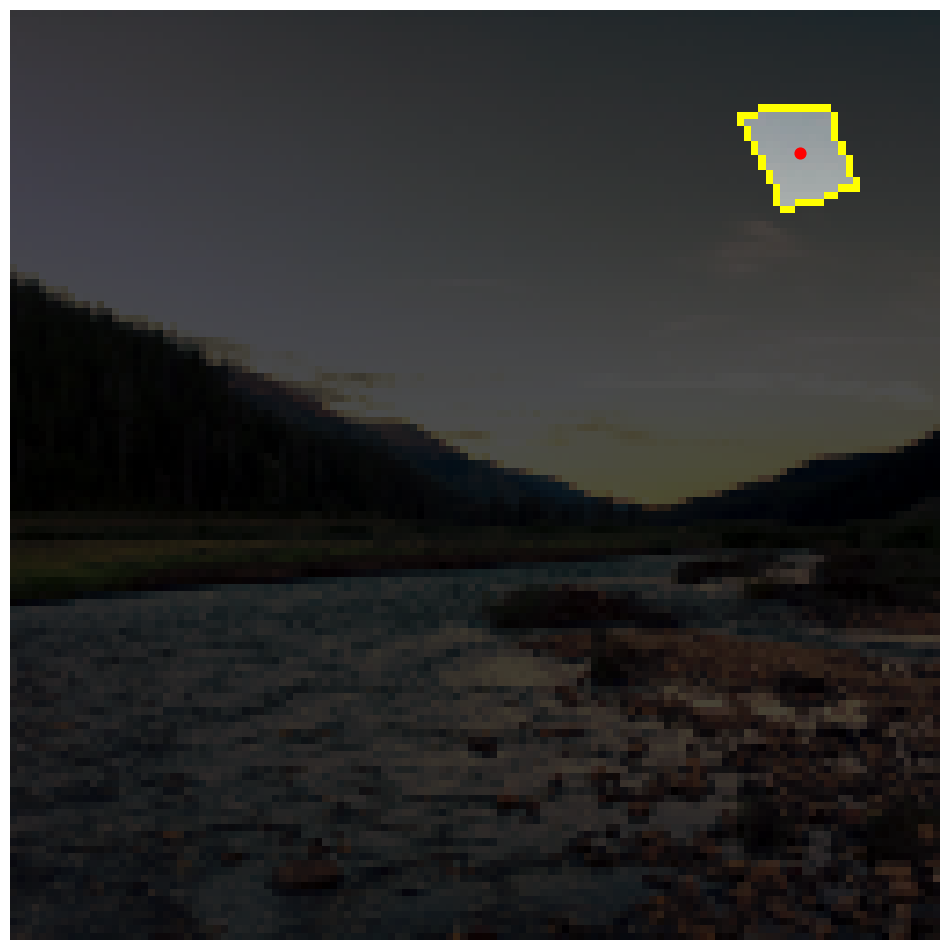

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def highlight_superpixels(image, segments, superpixel_ids):
    """Highlight specific superpixels and their boundaries."""
    mask_segment = np.zeros_like(segments, dtype=np.uint8)
    for superpixel_id in superpixel_ids:
        mask_segment = cv2.bitwise_or(mask_segment, (segments == superpixel_id).astype(np.uint8))

    highlighted_image = image.copy()
    highlighted_image[mask_segment == 0] = (highlighted_image[mask_segment == 0] * 0.3).astype(np.uint8)

    contours, _ = cv2.findContours(mask_segment, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundary_image = highlighted_image.copy()
    cv2.drawContours(boundary_image, contours, -1, (255, 255, 0), 1)
    #show_image(highlighted_image, 'Highlighted Superpixels')
    #show_image(boundary_image, 'Highlighted Superpixels with Boundaries')
    
    fig, ax = plt.subplots(figsize=(12, 20))
    coords = np.argwhere(mask_segment)
    centroid_x = coords[:, 1].mean() / image.shape[1]  # Normalize by width
    centroid_y = coords[:, 0].mean() / image.shape[0]  # Normalize by height
    ax.imshow(boundary_image)
    ax.scatter(centroid_x * image.shape[1], centroid_y * image.shape[0], color='red', s=60)
    plt.axis('off')
    plt.show()
    

superpixel_ids = [18]
highlight_superpixels(eq_image, segments, superpixel_ids)

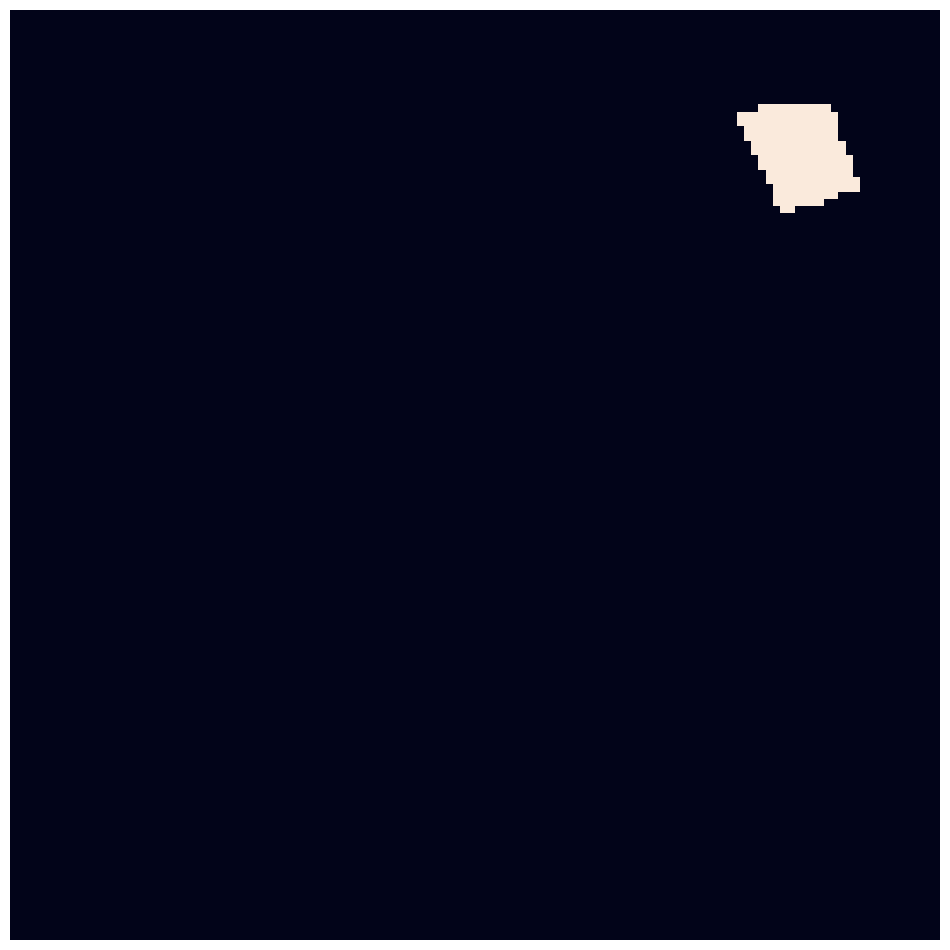

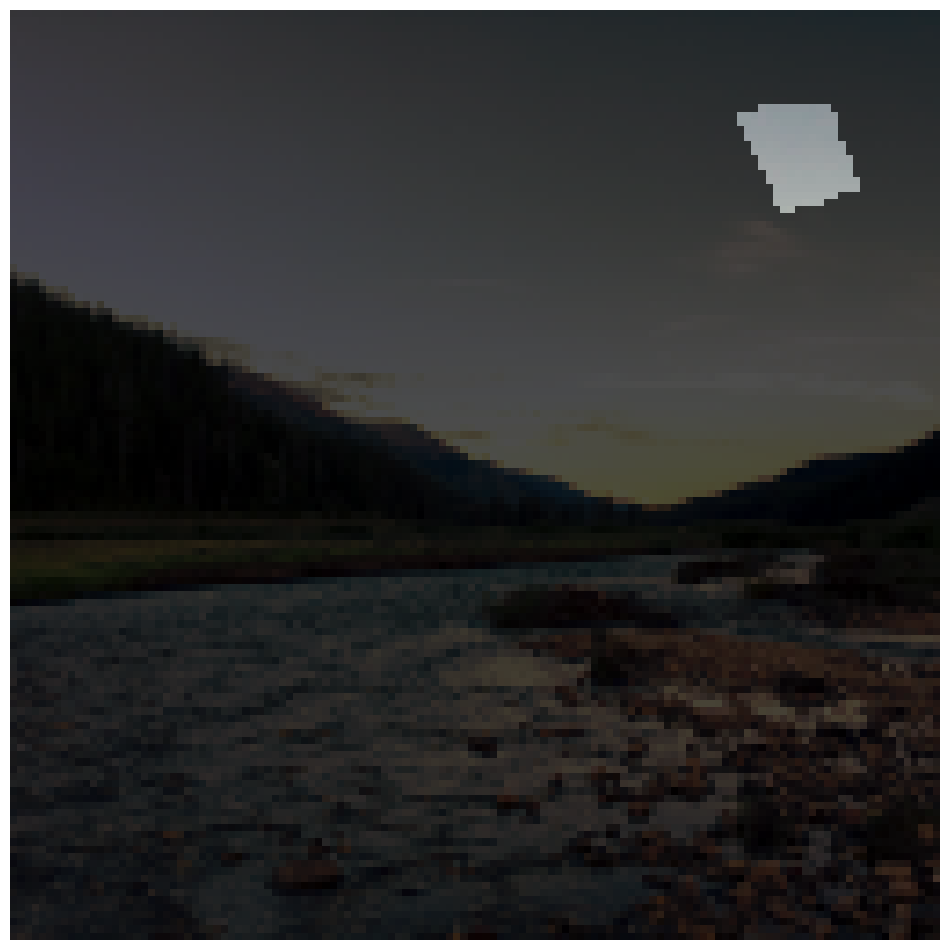

In [64]:
superpixel_id = [18, 43, 60]
mask_segment = segments == 18
show_image(mask_segment)
highlighted_image = eq_image.copy()
highlighted_image[~mask_segment] = (highlighted_image[~mask_segment] * 0.3).astype(np.uint8)
show_image(highlighted_image, 'superpixel')

In [65]:
img = eq_image
mean_color = img[mask_segment].mean(axis=0)
mean_color

array([154.14619883, 161.02339181, 162.92397661])

/home/aneta/Documents/UNN/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


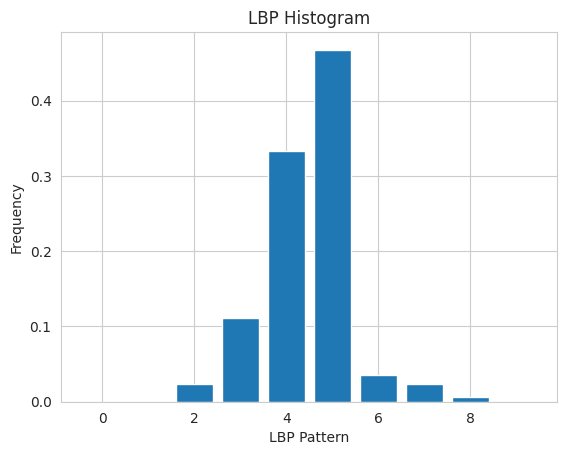

In [66]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

if img.ndim == 3:
    gray_img = rgb2gray(img)
else:
    gray_img = img
lbp = local_binary_pattern(gray_img, P=8, R=1, method="uniform")
lbp_hist = np.histogram(lbp[mask_segment], bins=np.arange(0, 11), density=True)[0]

plt.bar(range(len(lbp_hist)), lbp_hist)
plt.xlabel('LBP Pattern')
plt.ylabel('Frequency')
plt.title('LBP Histogram')
plt.show()

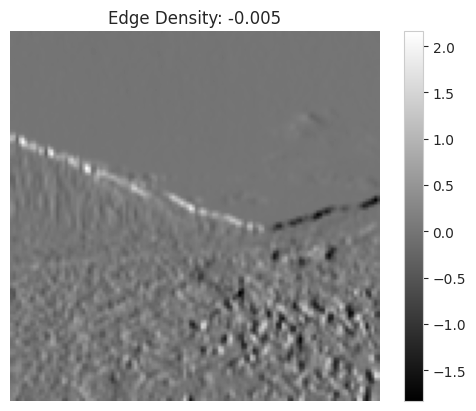

In [67]:
from scipy.ndimage import sobel

edge_map = sobel(gray_img)
edge_density = edge_map[mask_segment].mean()
plt.imshow(edge_map, cmap='gray')
plt.colorbar()
plt.title(f'Edge Density: {edge_density:.3f}')
plt.axis('off')
plt.show()

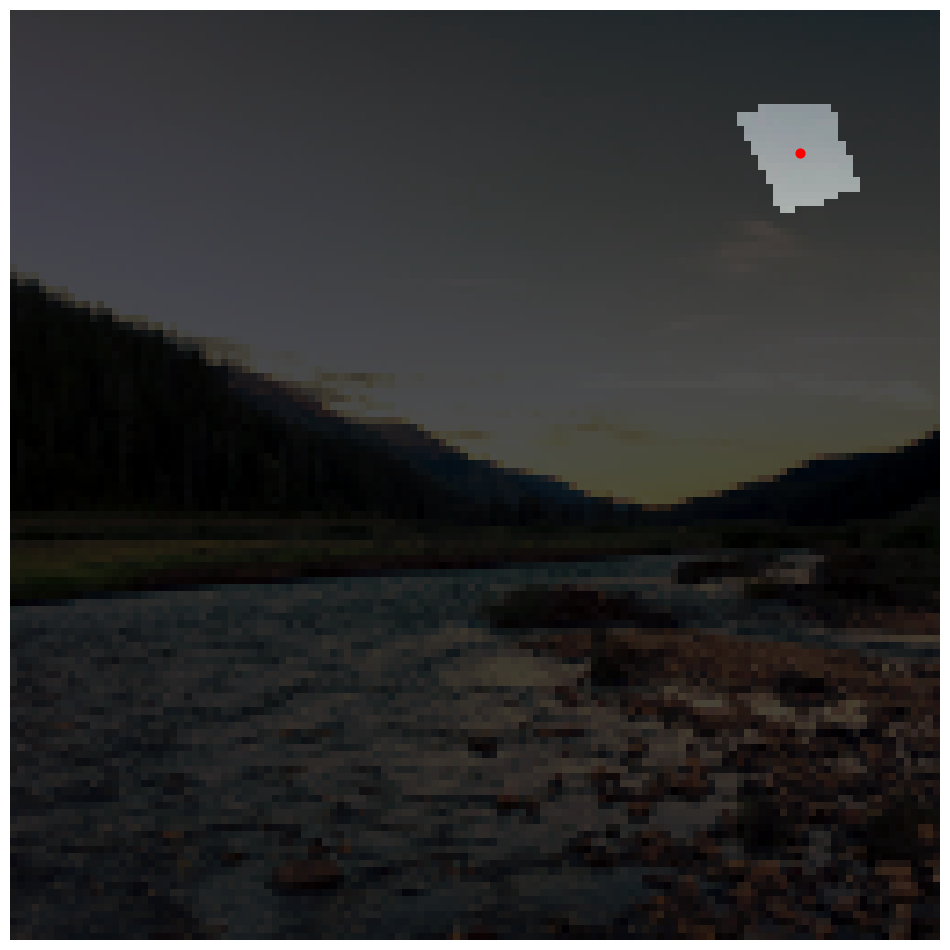

In [68]:
fig, ax = plt.subplots(figsize=(12, 20))
coords = np.argwhere(mask_segment)
centroid_x = coords[:, 1].mean() / img.shape[1]  # Normalize by width
centroid_y = coords[:, 0].mean() / img.shape[0]  # Normalize by height
ax.imshow(highlighted_image)
ax.scatter(centroid_x * img.shape[1], centroid_y * img.shape[0], color='red', s=40)
plt.axis('off')
plt.show()

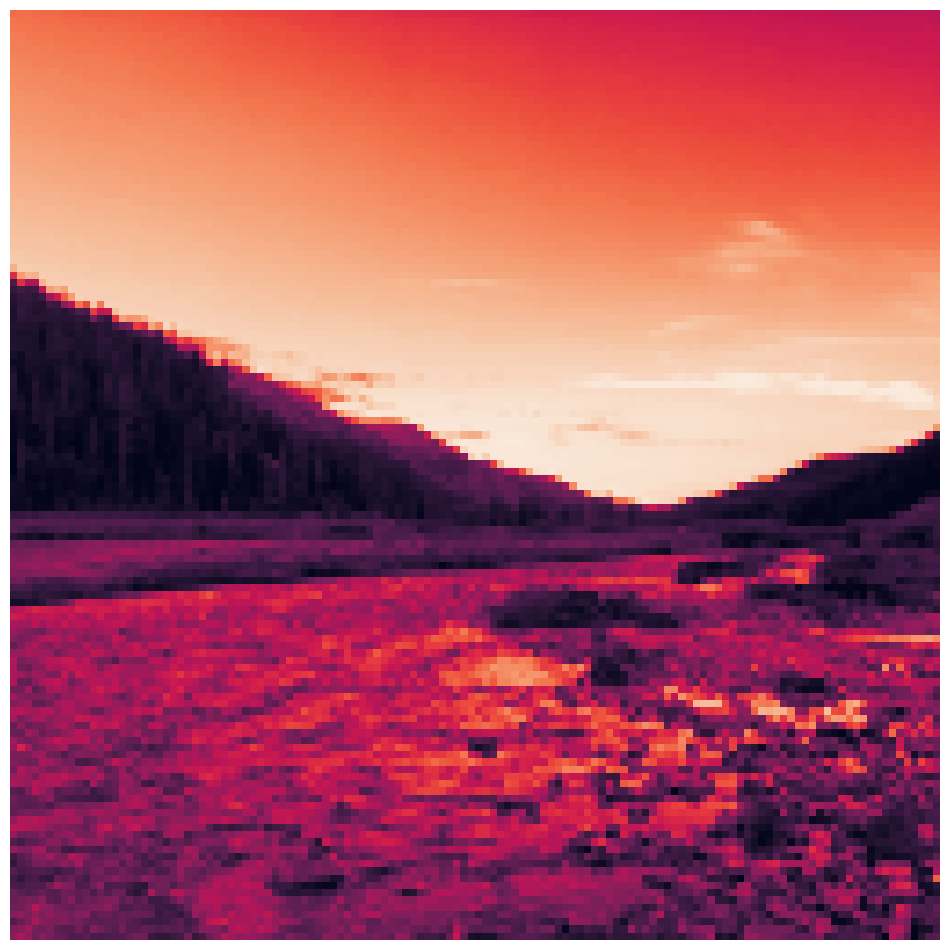

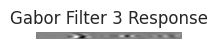

In [70]:
# Step 4b: Visualize Gabor filter responses
gray = rgb2gray(eq_image)
show_image(gray,'gray')
gabor_responses = [convolve(gray, np.real(kernel), mode='reflect') for kernel in gabor_filter_bank]
gabor_responses = np.array(gabor_responses)

plt.subplot(2, 3, 5)
for idx, response in enumerate(gabor_responses.transpose(2, 0, 1)):
    if idx >= 3:  # Show first three filters only
        break
    plt.imshow(response, cmap="gray")
    plt.title(f"Gabor Filter {idx+1} Response")
    plt.axis("off")

plt.show()

Channel B:
  Mean: 154.15
  Variance: 64.66
  Skewness: 0.09
  Kurtosis: -1.06
  Energy: 1895.00
Channel G:
  Mean: 161.02
  Variance: 49.99
  Skewness: 0.29
  Kurtosis: -0.94
  Energy: 1503.00
Channel R:
  Mean: 162.92
  Variance: 26.54
  Skewness: 0.19
  Kurtosis: -1.03
  Energy: 1729.00


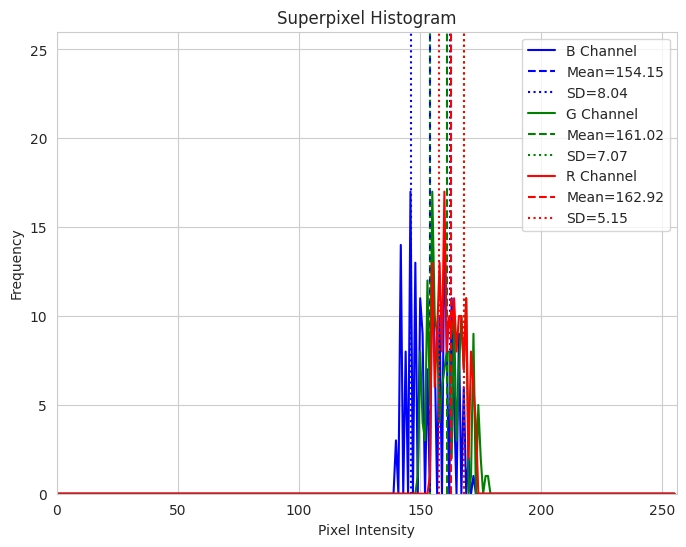

In [71]:
 # Step 4a: Extract histogram and visualize
mask_segment = mask_segment.astype(np.uint8)
chans = cv2.split(eq_image)
colors = ("b", "g", "r")
    
plt.figure(figsize=(8, 6))

for (chan, color) in zip(chans, colors):
        # Calculate the histogram for the masked region
        hist = cv2.calcHist([chan], [0], mask_segment, [256], [0, 256]).flatten()
    
        # Normalize histogram to represent pixel intensity frequencies
        hist_values = np.repeat(np.arange(256), hist.astype(int))
    
        # Compute statistics based on histogram pixel intensities
        hist_mean = np.mean(hist_values)
        hist_var = np.var(hist_values)
        hist_skewness = skew(hist_values)
        hist_kurtosis = kurtosis(hist_values)
        hist_energy = np.sum(hist**2)
    
        # Plot the histogram
        plt.plot(hist, color=color, label=f"{color.upper()} Channel")
        plt.xlim([0, 256])
        plt.ylim([0, 26])
    
        # Add mean, variance, skewness, and kurtosis annotations
        plt.axvline(hist_mean, color=color, linestyle="--", label=f"Mean={hist_mean:.2f}")
        plt.axvline(hist_mean + np.sqrt(hist_var), color=color, linestyle=":", label=f"SD={np.sqrt(hist_var):.2f}")
        plt.axvline(hist_mean - np.sqrt(hist_var), color=color, linestyle=":")
    
        # Log detailed statistics
        print(f"Channel {color.upper()}:")
        print(f"  Mean: {hist_mean:.2f}")
        print(f"  Variance: {hist_var:.2f}")
        print(f"  Skewness: {hist_skewness:.2f}")
        print(f"  Kurtosis: {hist_kurtosis:.2f}")
        print(f"  Energy: {hist_energy:.2f}")
    
plt.legend()
plt.title("Superpixel Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

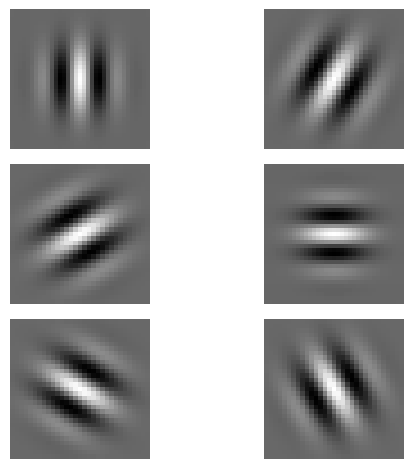

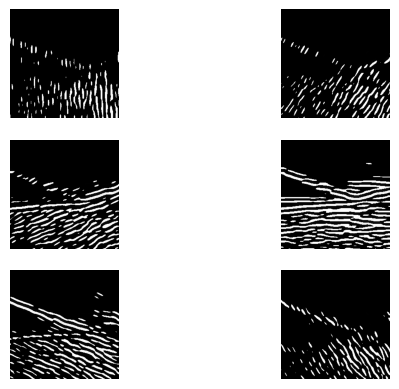

In [72]:
filter_bank = generate_gabor_filter_bank()

responses = extract_gabor_features(image, filter_bank)
    
    # Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(3, 2)
    
    # Middle: Gabor filters (2x3 grid)
for i, kernel in enumerate(filter_bank):
        row, col = divmod(i, 2)  # Calculate position in 2x3 grid
        axes[row, col].imshow(np.real(kernel), cmap='gray')
        axes[row, col].axis('off')
    
    # Right: Filter responses (2x3 grid)
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(3, 2)
for i in range(len(filter_bank)):
        row, col = divmod(i, 2)  # Calculate position in 2x3 grid
        axes[row, col].imshow(responses[..., i], cmap='gray')
        axes[row, col].axis('off')
    
    # Adjust layout
plt.margins(0.0015, tight=True)
plt.show()